### Importando bibliotecas

In [ ]:
!pip install pymysql
import pymysql
import pandas as pd
import os
from pyspark.sql import SparkSession

     |████████████████████████████████| 44 kB 879 kB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-2a49fc85-a66a-43f1-8d9b-50e48a38d43f/bin/python -m pip install --upgrade pip' command.


### Configurações do banco de dados MySQL

In [ ]:
# Configurações do MySQL a partir das variáveis de ambiente
mysql_host = os.getenv('MYSQL_HOST')
mysql_port = int(os.getenv('MYSQL_PORT'))
mysql_user = os.getenv('MYSQL_USER')
mysql_password = os.getenv('MYSQL_PASSWORD')
mysql_db = os.getenv('MYSQL_DB')
mysql_table = os.getenv('MYSQL_TABLE')


# Conectando ao MySQL
connection = pymysql.connect(
    host=mysql_host,
    port=mysql_port,
    user=mysql_user,
    password=mysql_password,
    database=mysql_db
)

### Leitura dos dados

In [ ]:
# Lendo dados da tabela para um DataFrame do pandas
query = f"SELECT * FROM {mysql_table}"
df = pd.read_sql(query, connection)

# Convertendo o DataFrame do pandas para um DataFrame do Spark
spark = SparkSession.builder.appName("Read MySQL Table").getOrCreate()
spark_df = spark.createDataFrame(df)

# Exibindo os dados
spark_df.show()


/databricks/python/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


+-------+------+----------------+--------------------+----------------------+---------------------+--------------+
|case_id|sex_id|hemoglobin_level|red_pixel_percentage|green_pixel_percentage|blue_pixel_percentage|anaemic_status|
+-------+------+----------------+--------------------+----------------------+---------------------+--------------+
|      1|     1|             6.3|             43.2555|               30.8421|              25.9025|             1|
|      2|     2|            13.5|             45.6033|                 28.19|              26.2067|             0|
|      3|     2|            11.7|             45.0107|               28.9677|              26.0215|             0|
|      4|     2|            13.5|             44.5398|               28.9899|              26.4703|             0|
|      5|     2|            12.4|              43.287|               30.6972|              26.0158|             0|
|      6|     1|            16.2|             45.0994|               27.9645|   

### Análise da qualidade dos dados

#### Valores Faltantes


In [ ]:
from pyspark.sql.functions import col, count, countDistinct, when

# Contar valores nulos por coluna
spark_df.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()


+-------+------+----------------+--------------------+----------------------+---------------------+--------------+
|case_id|sex_id|hemoglobin_level|red_pixel_percentage|green_pixel_percentage|blue_pixel_percentage|anaemic_status|
+-------+------+----------------+--------------------+----------------------+---------------------+--------------+
|      0|     0|               0|                   0|                     0|                    0|             0|
+-------+------+----------------+--------------------+----------------------+---------------------+--------------+



#### Valores Únicos e Distribuição

In [ ]:
# Valores únicos por coluna
spark_df.select([countDistinct(c).alias(c) for c in spark_df.columns]).show()

# Contagem de valores por coluna (para categóricas)
spark_df.groupBy("sex_id").count().show()
spark_df.groupBy("anaemic_status").count().show()

+-------+------+----------------+--------------------+----------------------+---------------------+--------------+
|case_id|sex_id|hemoglobin_level|red_pixel_percentage|green_pixel_percentage|blue_pixel_percentage|anaemic_status|
+-------+------+----------------+--------------------+----------------------+---------------------+--------------+
|    104|     2|              62|                 103|                   103|                  103|             2|
+-------+------+----------------+--------------------+----------------------+---------------------+--------------+

+------+-----+
|sex_id|count|
+------+-----+
|     1|   26|
|     2|   78|
+------+-----+

+--------------+-----+
|anaemic_status|count|
+--------------+-----+
|             0|   78|
|             1|   26|
+--------------+-----+



#### Estatísticas Descritivas

In [ ]:
# Estatísticas descritivas para colunas numéricas
spark_df.describe(["red_pixel_percentage", "green_pixel_percentage", "blue_pixel_percentage", "hemoglobin_level"]).show()

+-------+--------------------+----------------------+---------------------+------------------+
|summary|red_pixel_percentage|green_pixel_percentage|blue_pixel_percentage|  hemoglobin_level|
+-------+--------------------+----------------------+---------------------+------------------+
|  count|                 104|                   104|                  104|               104|
|   mean|           45.654175|     28.87550673076923|   25.470325000000003|12.150961538461539|
| stddev|  2.8162939069011492|    1.5542751246668467|   1.9846714900084668| 2.512956530220567|
|    min|             38.7968|               25.1403|              19.5413|                10|
|    max|             54.6478|               32.3681|              29.8414|               9.9|
+-------+--------------------+----------------------+---------------------+------------------+



####  Tratamento de Outliers

In [ ]:
# Converter colunas de string para float
spark_df = spark_df.withColumn("red_pixel_percentage", col("red_pixel_percentage").cast("float"))
spark_df = spark_df.withColumn("green_pixel_percentage", col("green_pixel_percentage").cast("float"))
spark_df = spark_df.withColumn("blue_pixel_percentage", col("blue_pixel_percentage").cast("float"))
spark_df = spark_df.withColumn("hemoglobin_level", col("hemoglobin_level").cast("float"))

# Utilizar o IQR (Interquartile Range) para detectar outliers
def outlier_boundaries(df, column):
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

red_pixel_bounds = outlier_boundaries(spark_df, "red_pixel_percentage")
green_pixel_bounds = outlier_boundaries(spark_df, "green_pixel_percentage")
blue_pixel_bounds = outlier_boundaries(spark_df, "blue_pixel_percentage")
hb_bounds = outlier_boundaries(spark_df, "hemoglobin_level")

# Filtrar outliers
spark_df_filtered = spark_df.filter((col("red_pixel_percentage").between(*red_pixel_bounds)) & 
                                    (col("green_pixel_percentage").between(*green_pixel_bounds)) & 
                                    (col("blue_pixel_percentage").between(*blue_pixel_bounds)) & 
                                    (col("hemoglobin_level").between(*hb_bounds)))

# Mostrar os dados filtrados
spark_df_filtered.show()


+-------+------+----------------+--------------------+----------------------+---------------------+--------------+
|case_id|sex_id|hemoglobin_level|red_pixel_percentage|green_pixel_percentage|blue_pixel_percentage|anaemic_status|
+-------+------+----------------+--------------------+----------------------+---------------------+--------------+
|      1|     1|             6.3|             43.2555|               30.8421|              25.9025|             1|
|      2|     2|            13.5|             45.6033|                 28.19|              26.2067|             0|
|      3|     2|            11.7|             45.0107|               28.9677|              26.0215|             0|
|      4|     2|            13.5|             44.5398|               28.9899|              26.4703|             0|
|      5|     2|            12.4|              43.287|               30.6972|              26.0158|             0|
|      6|     1|            16.2|             45.0994|               27.9645|   

In [ ]:
original_count = spark_df.count()
print(f"Total de registros no DataFrame original: {original_count}")

filtered_count = spark_df_filtered.count()
print(f"Total de registros no DataFrame filtrado: {filtered_count}")


Total de registros no DataFrame original: 104
Total de registros no DataFrame filtrado: 91


### Heatmap da correlação

/databricks/python/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1327: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/databricks/python/lib/python3.9/site-packages/matplotlib/axes/_base.py:506: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


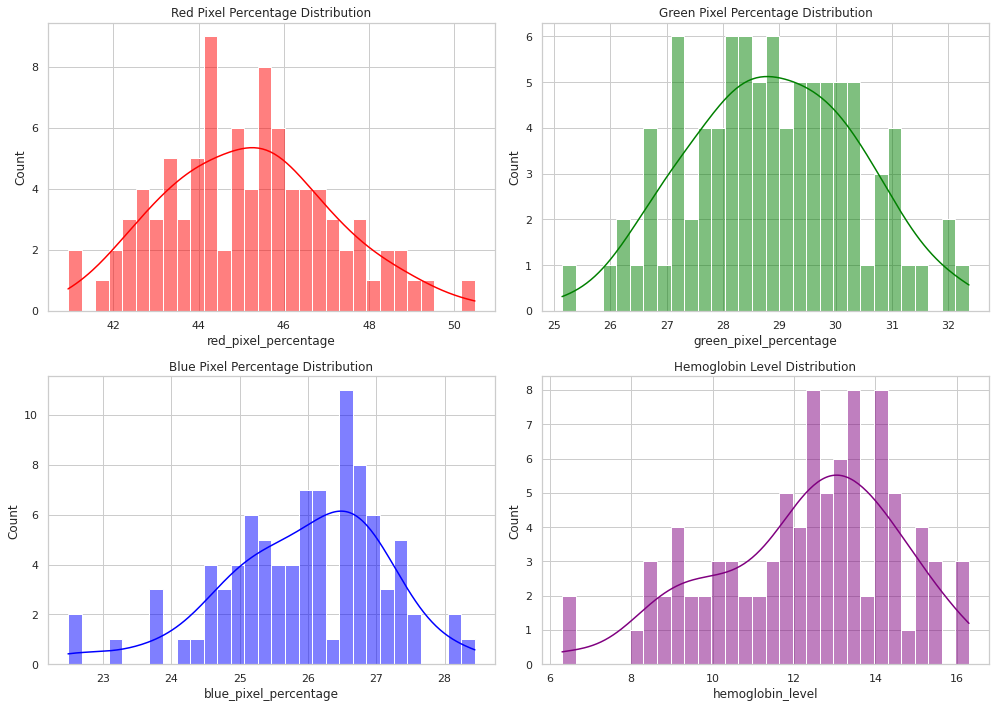

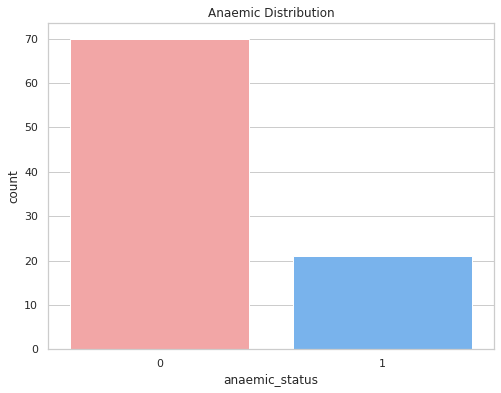

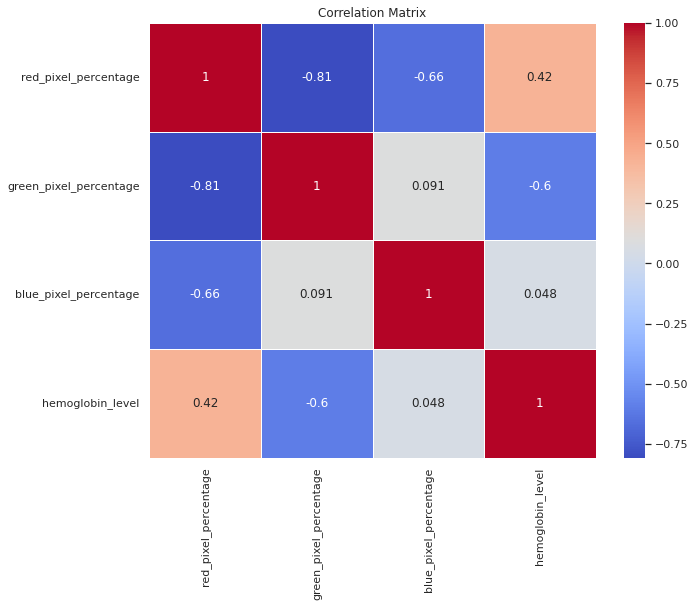

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração geral do Seaborn
sns.set(style="whitegrid")

# Criando DataFrame para visualização
df_visual = spark_df_filtered.toPandas()

# Histogramas das variáveis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(df_visual['red_pixel_percentage'], bins=30, kde=True, ax=axes[0, 0], color='red').set(title='Red Pixel Percentage Distribution')
sns.histplot(df_visual['green_pixel_percentage'], bins=30, kde=True, ax=axes[0, 1], color='green').set(title='Green Pixel Percentage Distribution')
sns.histplot(df_visual['blue_pixel_percentage'], bins=30, kde=True, ax=axes[1, 0], color='blue').set(title='Blue Pixel Percentage Distribution')
sns.histplot(df_visual['hemoglobin_level'], bins=30, kde=True, ax=axes[1, 1], color='purple').set(title='Hemoglobin Level Distribution')

plt.tight_layout()
plt.show()

# Gráfico de Barras para o Indicador de Anemia
plt.figure(figsize=(8, 6))
sns.countplot(data=df_visual, x='anaemic_status', palette=['#ff9999','#66b3ff']).set(title='Anaemic Distribution')
plt.show()

# Heatmap de Correlação
plt.figure(figsize=(10, 8))
correlation_matrix = df_visual[['red_pixel_percentage', 'green_pixel_percentage', 'blue_pixel_percentage', 'hemoglobin_level']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5).set(title='Correlation Matrix')
plt.show()
